In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install healpy
!pip install git+https://github.com/vafaei-ar/ccgpack.git

     |████████████████████████████████| 23.6 MB 57.5 MB/s 
  Cloning https://github.com/vafaei-ar/ccgpack.git to /tmp/pip-req-build-u8o6oqt7
  Running command git clone -q https://github.com/vafaei-ar/ccgpack.git /tmp/pip-req-build-u8o6oqt7
  Created wheel for ccgpack: filename=ccgpack-0.1.0-cp37-cp37m-linux_x86_64.whl size=912872 sha256=1c3e46111bea692fd0353a41037afbed0a40b7067da61a4e01720fd216285ef0
  Stored in directory: /tmp/pip-ephem-wheel-cache-akxwhark/wheels/12/6f/95/7ae57565d174cea0e92a0da0a36f289e045f46ef2173da656b
Successfully built ccgpack


In [ ]:
import numpy as np
import healpy as hp
import pylab as plt
import ccgpack as ccg

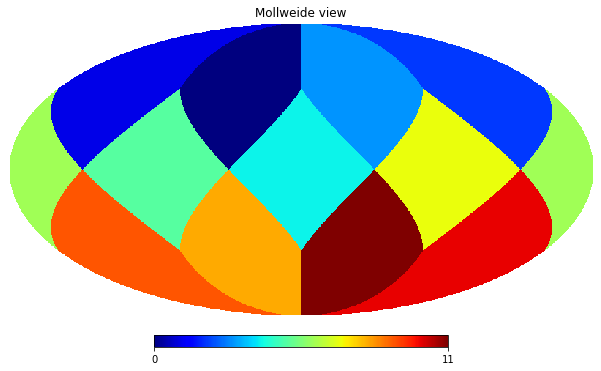

In [ ]:
cmap = plt.cm.get_cmap('jet')
hp.mollview(np.arange(12),nest=1,cmap = cmap)

In [ ]:
map = '/content/drive/MyDrive/CMB/map1n_allz_rtaapixlw_2048_2.fits'
string_map = hp.read_map(map,nest=1,verbose=0)

In [ ]:
gauss = "/content/drive/MyDrive/CMB/product-action?SIMULATED_MAP.FILE_ID=febecop_ffp10_lensed_scl_cmb_100_mc_0000.fits"
gaussian_map = hp.read_map(gauss,nest=1,verbose=0)


In [ ]:
g_mu = 1e-6
cmb_with_string = gaussian_map + (g_mu * string_map)

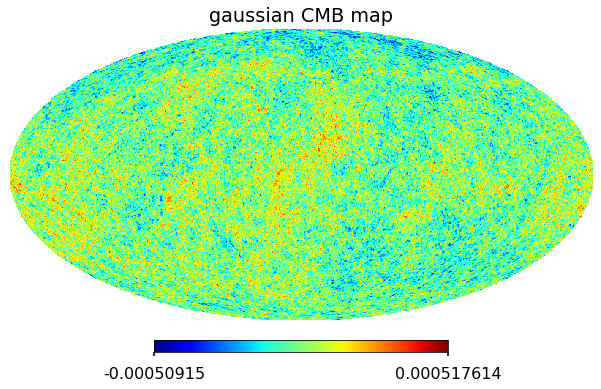

In [ ]:
hp.mollview(gaussian_map,nest=1,cmap = cmap, title='gaussian CMB map')

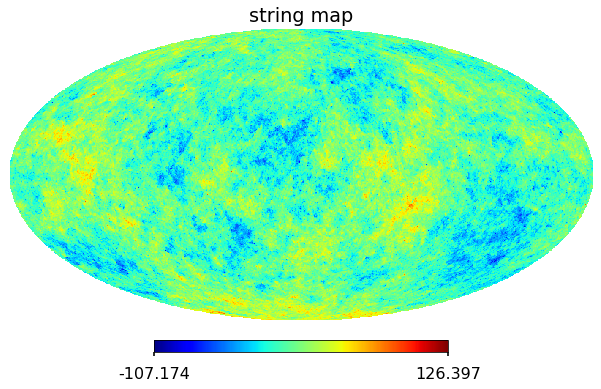

In [ ]:
hp.mollview(string_map,nest=1,cmap = cmap, title='string map')

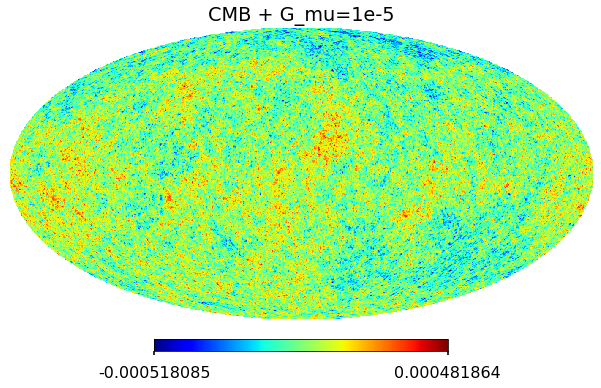

In [ ]:
hp.mollview(cmb_with_string,nest=1,cmap = cmap, title='CMB + G_mu=1e-5')

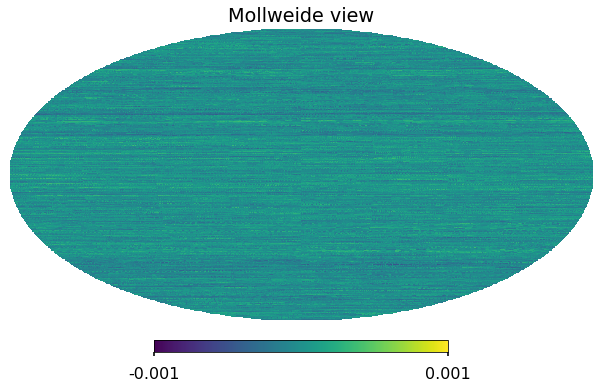

In [ ]:
hp.mollview(cmb_with_string, min=-1e-3, max=1e-3)

### **Compute The Power Spectrum**


---



In [ ]:
!wget https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-TT-binned_R3.01.txt


--2022-03-01 09:00:55--  https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-TT-binned_R3.01.txt
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.87
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7143 (7.0K) [text/plain]
Saving to: ‘COM_PowerSpect_CMB-TT-binned_R3.01.txt’

COM_PowerSpect_CMB- 100%[===================>]   6.98K  --.-KB/s    in 0s      

2022-03-01 09:00:55 (136 MB/s) - ‘COM_PowerSpect_CMB-TT-binned_R3.01.txt’ saved [7143/7143]



In [ ]:
cmb_binned_spectrum = np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt')

In [ ]:
!wget https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits

In [ ]:
path = '/content/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits'
mask = hp.read_map(path)
map_masked = hp.ma(cmb_with_string)
map_masked.mask = np.logical_not(mask)

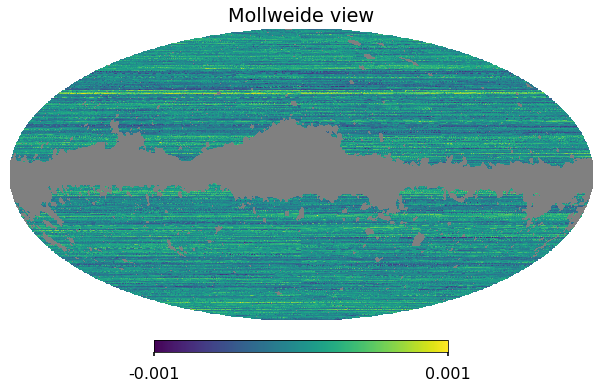

In [ ]:
hp.mollview(map_masked, min=-1e-3, max=1e-3)

In [ ]:
lmax = 3000

In [ ]:
test_cls_meas_frommap = hp.anafast(map_masked, lmax=lmax, use_pixel_weights=True)

In [ ]:
ll = np.arange(lmax+1)

In [ ]:
sky_fraction = len(map_masked.compressed()) / len(map_masked)

In [ ]:
print(f"The map covers {sky_fraction:.1%} of the sky")

The map covers 77.9% of the sky


In [ ]:
plt.style.use("seaborn-poster")

In [ ]:
k2muK = 1e5

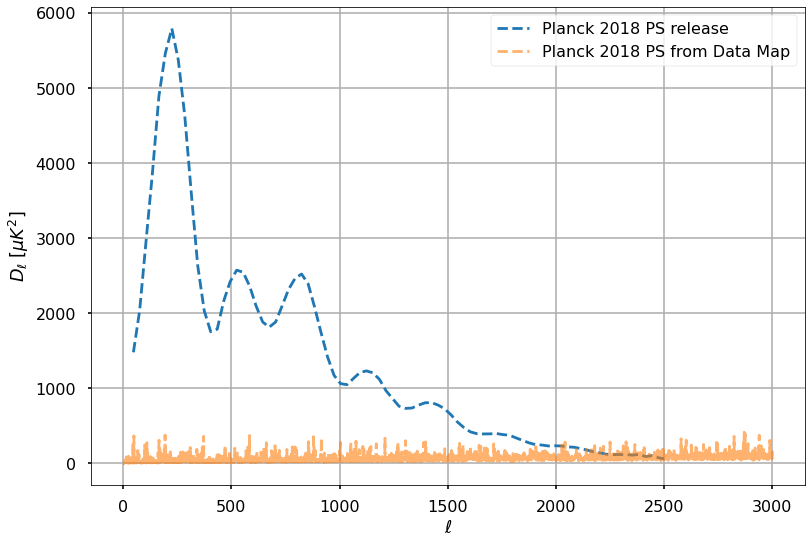

In [ ]:
plt.plot(cmb_binned_spectrum[:,0], cmb_binned_spectrum[:,1], '--', alpha=1, label='Planck 2018 PS release')
plt.plot(ll, ll*(ll+1.)*test_cls_meas_frommap*k2muK**2/2./np.pi / sky_fraction, '--', alpha=0.6, label='Planck 2018 PS from Data Map')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell~[\mu K^2]$')
plt.grid()
plt.legend(loc='best')

In [ ]:
import astropy.units as u
w_ell = hp.gauss_beam((5*u.arcmin).to_value(u.radian), lmax=lmax)

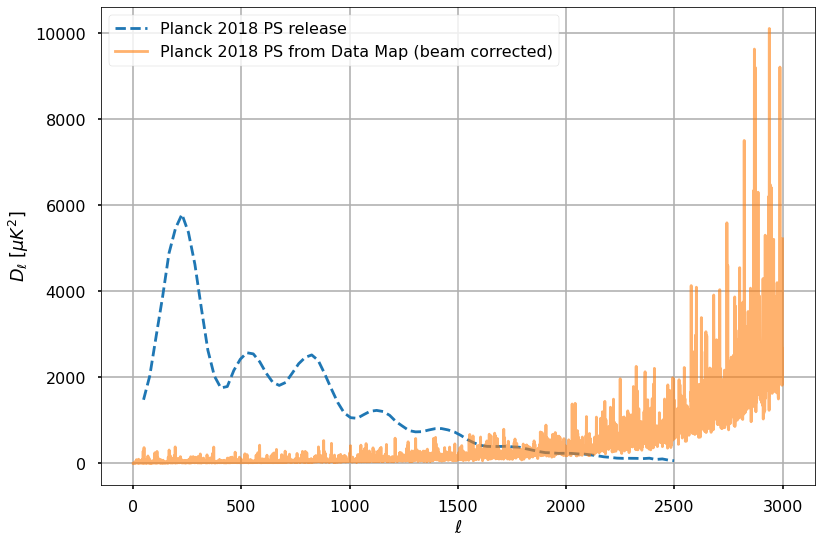

In [ ]:
plt.plot(cmb_binned_spectrum[:,0], cmb_binned_spectrum[:,1], '--', alpha=1, label='Planck 2018 PS release')
plt.plot(ll, ll*(ll+1.)*test_cls_meas_frommap*k2muK**2/2./np.pi / sky_fraction / w_ell**2,
         alpha=0.6, label='Planck 2018 PS from Data Map (beam corrected)')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell~[\mu K^2]$')
plt.grid()
plt.legend(loc='best');

In [ ]:
    def view(self, idx=0, logged=False):
        """ View generated map using healpy's mollweide projection.

        Parameters
        ----------
        idx: int
            index of map to view. Only required if you generated maps at
            multiple frequencies.
        logged: bool
            Take the log of the data before plotting. Defaults to False.

        """

        if self.generated_map_data is None:
            raise RuntimeError("No GSM map has been generated yet. Run generate() first.")

        if self.generated_map_data.ndim == 2:
            gmap = self.generated_map_data[idx]
            freq = self.generated_map_freqs[idx]
        else:
            gmap = self.generated_map_data
            freq = self.generated_map_freqs

        if logged:
            gmap = np.log2(gmap)

        hp.mollview(gmap, coord='G',
                    title='Global Sky Model %s %s' % (str(freq), self.unit))
        plt.show()